In [5]:
# ! pip install seaborn==0.13.0
# ! pip install matplotlib==3.7.3

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

from utils import read_result, read_result_reverse

dataset_dict = {
    "dataset1": "1: SimSame",
    "dataset2": "2: SimDiff",
    "dataset3": "3: DisSame",
    "dataset4": "4: DisDiff",
}

FONTSIZE = 16
FIGSIZE = (9, 4)

# UnTrac

In [7]:
import os, glob

root = "unlearn_outputs"
dataset_names = [os.path.basename(p) for p in glob.glob(f"{root}/*") if os.path.isdir(p)]

missing = []
for n in dataset_names:
    p = os.path.join(root, n, "trainer_state.json")
    if os.path.isfile(p):
        print("OK     :", p)
    else:
        print("MISSING:", p)
        
        for alt in ("results.json", "metrics.json"):
            q = os.path.join(root, n, alt)
            if os.path.isfile(q):
                print("  found alt:", q)
                break
        else:
            missing.append(p)

assert not missing, "Still missing:\n" + "\n".join(missing)


OK     : unlearn_outputs/dataset4/trainer_state.json
OK     : unlearn_outputs/dataset3/trainer_state.json
OK     : unlearn_outputs/dataset1/trainer_state.json
OK     : unlearn_outputs/dataset2/trainer_state.json


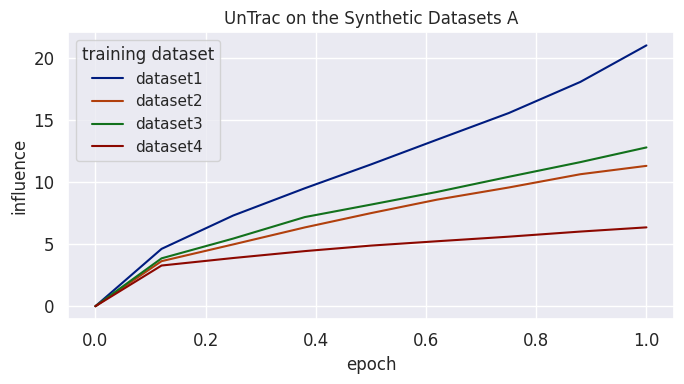

In [8]:
from utils import read_result
import os, glob, seaborn as sns, matplotlib.pyplot as plt

dataset_names = sorted(
    os.path.basename(p) for p in glob.glob("unlearn_outputs/*") if os.path.isdir(p)
)

df_result = read_result(
    output_dir_format="unlearn_outputs/{}/",  
    dataset_names=dataset_names,
    key_column="epoch",
    init_dir="model/t5_00",                  
)


dataset_dict = {name: name for name in dataset_names}

df_plot = df_result.copy()
df_plot["training dataset"] = df_plot.index.map(lambda n: dataset_dict.get(n, n))

FIGSIZE, FONTSIZE = (7, 4), 12
plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(
    data=df_plot.reset_index(), 
    x="epoch", y="dataset0", hue="training dataset", palette="dark"
)
ax.set_title("UnTrac on the Synthetic Datasets A", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE)
ax.set_ylabel("influence", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE); plt.yticks(fontsize=FONTSIZE);
plt.tight_layout()


In [9]:
print(df_result.shape)
print(df_result.columns.tolist())
print(df_result.head())


if {"epoch","dataset_name","eval_loss"}.issubset(df_result.columns):
    print("unique dataset_name:", df_result["dataset_name"].unique())


(36, 2)
['dataset0', 'epoch']
              dataset0  epoch
dataset_name                 
dataset1      4.625123   0.12
dataset2      3.633437   0.12
dataset3      3.860868   0.12
dataset4      3.282025   0.12
dataset1      7.315084   0.25


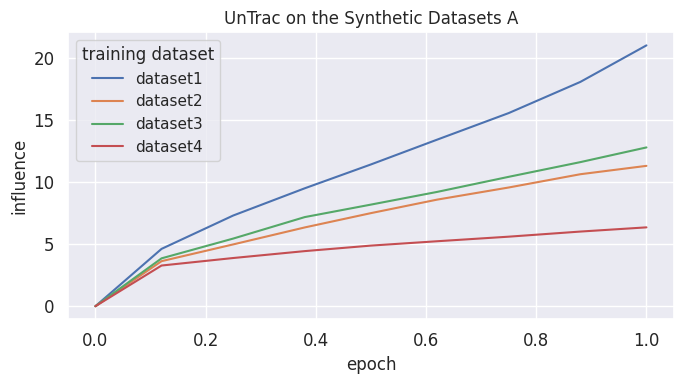

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_long = df_result.reset_index().rename(
    columns={"dataset0": "influence", "dataset_name": "training dataset"}
)


df_long["epoch"] = pd.to_numeric(df_long["epoch"])
df_long = df_long.sort_values(["training dataset", "epoch"])

plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(
    x="epoch", y="influence", hue="training dataset",
    data=df_long, estimator=None, errorbar=None  
)
ax.set_title("UnTrac on the Synthetic Datasets A", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE)
ax.set_ylabel("influence", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()


# UnTrac-Inv

In [11]:
import os, glob

root = "untrac_inv_outputs"
dataset_names = [os.path.basename(p) for p in glob.glob(f"{root}/*") if os.path.isdir(p)]

missing = []
for n in dataset_names:
    p = os.path.join(root, n, "trainer_state.json")
    if os.path.isfile(p):
        print("OK     :", p)
    else:
        print("MISSING:", p)
        
        for alt in ("results.json", "metrics.json"):
            q = os.path.join(root, n, alt)
            if os.path.isfile(q):
                print("  found alt:", q)
                break
        else:
            missing.append(p)

assert not missing, "Still missing:\n" + "\n".join(missing)


OK     : untrac_inv_outputs/synthetic_train01_dataset/trainer_state.json
OK     : untrac_inv_outputs/synthetic_train00_dataset/trainer_state.json
OK     : untrac_inv_outputs/synthetic_train10_dataset/trainer_state.json


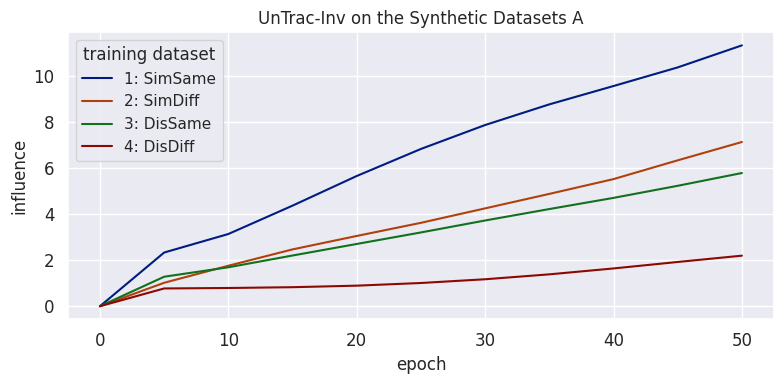

In [12]:
import os, glob, re
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from utils import read_result

runs = ["synthetic_train00_dataset", "synthetic_train10_dataset"]

df = read_result(
    output_dir_format="untrac_inv_outputs/{}/",
    dataset_names=runs,
    key_column="epoch",
    init_dir=f"untrac_inv_outputs/{runs[0]}",
)

ds_cols = [c for c in df.columns if re.fullmatch(r"dataset[1-4]", c)]
if not ds_cols:
    ds_cols = sorted(
        [c for c in df.columns if c.startswith("dataset") and c != "dataset0"],
        key=lambda s: int(re.findall(r"\d+", s)[0])
    )
assert ds_cols, f"df.columns: {list(df.columns)[:20]}"

df = df.reset_index().rename(columns={df.index.name or "index": "run"})
df_long = df.melt(
    id_vars=["run", "epoch"],
    value_vars=ds_cols,
    var_name="training dataset",
    value_name="influence",
)

label_map = {
    "dataset1": "1: SimSame",
    "dataset2": "2: SimDiff",
    "dataset3": "3: DisSame",
    "dataset4": "4: DisDiff",
}
df_long["training dataset"] = df_long["training dataset"].map(label_map).fillna(df_long["training dataset"])

df_plot = df_long.groupby(["epoch", "training dataset"], as_index=False)["influence"].mean()

FIGSIZE, FONTSIZE = (8, 4), 12
plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(
    data=df_plot,
    x="epoch", y="influence",
    hue="training dataset",
    palette="dark",
    errorbar=None  
)
ax.set_title("UnTrac-Inv on the Synthetic Datasets A", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE)
ax.set_ylabel("influence", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE); plt.yticks(fontsize=FONTSIZE); plt.tight_layout()
plt.show()
